# Markov Chains and MCMC

##### Keywords: markov chain, MCMC, detailed balance, metropolis,  stationarity, ergodicity, transition matrix,  metropolis-hastings, irreducible

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Contents
{:.no_toc}
* 
{: toc}

## Markov chains

Markov Chains are the first example of a **stochastic process** we will see in this class.  The values in a Markov chain depend on the previous values (probabilistically), with the defining characteristic being that a given value is depenendent only on the immediate previous value.

This is certainly not IID (idenpendently and identically distributed) data, which is what we have been assuming so far and will generally assume in this course, unless specified otherwise...

**Definition**: A sequence of random variables taking values in a state space is called a Markov Chain if the probability of the next step only depends on the current state.

Using the notation of transition probabilities to define the probability of going from state $x$ ot state $y$ as $T(x \vert y)$, we can write this mathematically:

$$T(x_n \vert x_{n-1}, x_{n-1}..., x_1) = T(x_n \vert x_{n-1})$$

## Some Jargon


### Homogeneous Markov Chain

A chain is homogeneous at step $t$ if the transition probabilities are independent of $t$. Thus the evolution of the Markov chain only depends on the previous state with a fixed transition matrix.

### Irreducible Markov Chains

Every state is accessible in a finite number of steps from another state. That is, there are no absorbing states. In other words, one eventually gets everywhere in the chain.

Consider as an example  surfing the web. We do want to reach all parts of the web so we dont want to be trapped into an subset.

### Recurrent

States visited repeatedly are recurrent: positive recurrent if time-to-return is bounded and null recurrent otherwise. Harris recurrent if all states  are visited infinitely often as $t \to \infty$

### Aperiodic

There are no deterministic loops. This would be bad in our web example as well as we would be stuck in a loop at some pages.

Indeed pagerank has 2 components: one mirroring the true web which can have periods and reducibility, and the second a nose component which "regularizes" the web by adding some noise to the transition matrix for 0 elements.

![](images/mchain2.png)

### Stationarity

We can finally give a formal definition of stationarity. A stationary Markov chain produces the same *marginal* distribution when multiplied by the transition matrix.

That is

$$sT = s$$

or

$$\sum_i s_i T_{ij} = s_j$$

or in the case of a continuous state space, which are the ones we encounter in sampling, if the Transition kernel T is defined so that

$$\int dx_i s(x_i) T(x_{i+1} \vert x_i) = s_(x_{i+1})$$

then

$$\int dx s(x) T(y \vert x) = \int p(y, x) dx = s(y)$$

Pagerank is  indeed the stationary distribution of its transition matrix (each web-page is a new x).

### Ergodicity

Aperiodic, irreducible, positive Harris recurrent  markov chains are ergodic, that is, in the limit of infinite (many) steps, the marginal distribution of the chain is the same. This means that if we take largely spaced about samples from a stationary markov chain, we can draw independent samples. 

$$\int g(x) f(x) dx  = \frac{1}{N} \sum_{j=B+1}^{B+N} g(x_j)$$

Here B is called the burin (which comes from the approach to stationarity after a while) and T is called the thinning (which comes from ergodicity). So we have this "ergodic" law of large numbers.

## Getting a stationary distribution

A irreducible (goes everywhere) and aperiodic (no cycles) markov chain  will converge to a stationary markov chain. It is the marginal distribution of this chain that we want to sample from, and which we do in metropolis (and for that matter, in simulated annealing).

As we can see above, to find stationary distribution, we need to solve an eigenvector proble. This can be hard. We can show that if we follow reversibility, we are golden...thus..

A sufficient, but not necessary, condition to ensure that  $s(x)$ is the desired stationary distribution is the already seen reversibility condition, also known as  detailed balance:

$$s(x) T(y \vert x) = s(y) T(x \vert y)$$

If one sums both sides over $x$

$$\int dx s(x) t(y \vert x) = s(y) \int dx T(x \vert y)$$ which gives us back the stationarity condition from above.

Thus we want to design us samplers which  satisfy detailed balance.

# Example Rainy - Sunny

We look at a very simple Markov Chain, with only two states: Rainy or Sunny. This chain is aperiodic and irreducible, so it has a stationary distribution. We find it by looking at powers of the transition matrix.

![](images/mchain.png)

In [2]:
# the transition matrix for our chain
transition_matrix = np.array([[1./3., 2./3.],[0.5, 0.5]])
transition_matrix

array([[ 0.33333333,  0.66666667],
       [ 0.5       ,  0.5       ]])

In [3]:

# now for higher n. We should see that it converges to the
# stationary distribution
tm_before = transition_matrix
for i in range(5):
    tm_next = np.dot(tm_before, transition_matrix)
    print(tm_next)
    print("-----------------")
    tm_before = tm_next

[[ 0.44444444  0.55555556]
 [ 0.41666667  0.58333333]]
-----------------
[[ 0.42592593  0.57407407]
 [ 0.43055556  0.56944444]]
-----------------
[[ 0.42901235  0.57098765]
 [ 0.42824074  0.57175926]]
-----------------
[[ 0.42849794  0.57150206]
 [ 0.42862654  0.57137346]]
-----------------
[[ 0.42858368  0.57141632]
 [ 0.42856224  0.57143776]]
-----------------


The stationary distribution can be solved for. Assume that it is $$s = [p, 1-p]$$.  Then:

$$sT = s$$

gives us

$$p \times (1/3) + (1-p) \times 1/2 =  p$$

and thus $p = 3/7$

In [4]:
3/7, 4/7

(0.42857142857142855, 0.5714285714285714)

And  we can see that we can get to this stationary distribution starting from multiple places

In [5]:
np.dot([0.5,0.5], tm_before)

array([ 0.42857296,  0.57142704])

In [6]:
np.dot([0.9,0.1], tm_before)

array([ 0.42858153,  0.57141847])

## Back to Metropolis

Now we can put our Metropolis sampler on a sure footing.  And this foOting based on Markov Chain theory is why we call this a **MCMC** or Markov Chain Monte Carlo technique.

Our game is this: we wish to find a markov chain whose stationary distribution is the distribution we need to sample from.

As long as we set up a sampling scheme that follows detailed balance we are ok.

$$ s(x_i)T( x_{i-1} \vert x_i ) = s(x_{i-1}) T( x_i \vert x_{i-1} )$$

### Proof of Detailed Balance

The transition matrix (or kernel) can be written in this form for Metropolis:

$$T(x_i \vert x_{i-1}) = q(x_i \vert x_{i-1})\,A(x_i, x_{i-1}) +  \delta(x_{i-1} - x_i)r(x_{i-1})$$

where

$$A(x_i, x_{i-1}) = min(1,  \frac{s(x_i)}{s(x_{i-1})})$$ 

is the Metropolis acceptance probability (you propose the move and accept it) and 

$$r(x_i) = \int dy q(y \vert x_i)(1 - A(y, x_i))$$ is the rejection term. In the event you dont move, this could have happened 2 ways: (a) you proposed to move to the same position and accepted it, or you proposes moves aevrywhere else but dont accept any of those proposals and stay where you are.

Lets parse the term above:

- the transition probability has two terms
- the first term is the probability of proposing a new $x_i$ times the probability of accepting it
- the second term is the probability $r(x_{i-1})$ of rejecting it with the delta function setting it so that $x_i = x_{i-1}$
- the integral adds over all the points $y$ that might have been proposed and then rejected, so we stayed at $x_{i-1}$

$$s(x_i)T( x_{i-1} \vert x_i ) =  s(x_i) q(x_{i-1} \vert x_{i})\,A(x_{i-1}, x_{i}) +  s(x_i) \delta(x_{i} - x_{i-1})r(x_{i})$$

$$s(x_{i-1})T( x_{i} \vert x_{i-1} ) =  s(x_{i-1}) q(x_i \vert x_{i-1})\,A(x_i, x_{i-1}) +  s(x_{i-1})\delta(x_{i-1} - x_i)r(x_{i-1})$$

The second term in each expression is equal.

Assume, without loss of generality that $s(x_i) < s(x_{i-1})$. Then the first term of the first expression gives us $s(x_i) q(x_{i-1} \vert x_i)$. The first term of the second expression gives us $s(x_{i}) q(x_i \vert x_{i-1})$. Since the proposals are symmetric, detailed balance holds.

Thus the  Metropolis algorithm  respects $s(x)$ as the stationary distribution.


### Intuition

All this math boils down to the following intuition:

![](images/mcapproach.png)


Instead of sampling $s$ (or $p$) (since we dont know how to do that) we sample $q$ instead.  Sampling from this distribution yields a new state, and a *new proposal distribution* from which to sample.

![](images/gsample.png)

In general such a markov chain would meander around. But the aperiodicity and irreducibility means that it will preserve the (stationary) target distribution and go for the typical set (red), no matter where it is applied. 


The possibility of rejection in the Metropolis algorithm based on the throw of a random uniform makes the chain aperiodic. And if we want it to be irreducible, we need to make sure $q$ can go everywhere that $p$ can, or that the support of $q$ includes everywhere the support of $p$. Thus our Metropolis algorithm converges.


## Onwards to Metropolis-Hastings

Prior to a full discussion of Metropolis Hastings, let us motivate the season why we may want to tinker with the Metropolis algorithm.

If you think about the $6x(1-x)$ "distribution" which we dont want to support outside of [0,1], we  realize, as seen in the diagram above, that a normal distribution as a proposal will still want  to sample stuff in negative areas and $>1$.  So we wastefully make acceptance probability comparisons.

Out intuition may be to reject samples outside the support. But as we shall show later, this makes our proposal asymmetric and we need to deal with this. This is because stepping to a negative number and coming back are not symmetric: one is rejected.

If we do it without taking into account this asymmetry, we will actually be sampling from a different distribution as we shall show later.

However, we may also want to sample from a asymmetric proposal like a beta function because its guaranteed to be positive.  However  a beta distribution is not symmetric.

Here is the outline code for metropolis hastings.

In [7]:
def metropolis_hastings(p,q, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i] = x_star
            x_prev = x_star
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples

Look at the `proposalratio` term. Its a ratio of proposal pdfs. But its opposite to the ratio of the pdf that we want to sample from.

What is the intuition behind this? Remember that because you dont know how to sample from $p$, you are sampling from $q$ instead.  Now if q is asymmetric, you will have a greater chance of going in one direction than the other. Indeed you are more likely to get samples from the region where $q$ (more precisely each new $q$) is high . This may not match with the $p$ you want to sample from, and you want to correct this oversampling by multiplying by the proposal ration. This helps erase the memory of $q$ a bit.

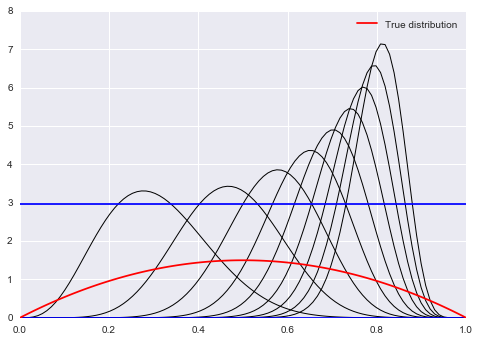

In [32]:
from scipy.stats import beta
f = lambda x: 6*x*(1-x)
xx= np.linspace(0,1,100)
for s in np.linspace(0,1,10):
    plt.plot(xx, beta.pdf(xx,40*s,10),'k', lw=1)
plt.axhline(beta.pdf(0.2, 20, 10),0,1)
plt.axhline(beta.pdf(0.5, 8, 10),0,1)


#plot the true function
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend();